Accuracy: 0.9544592030360531

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      1198
           1       1.00      0.90      0.94       910

    accuracy                           0.95      2108
   macro avg       0.96      0.95      0.95      2108
weighted avg       0.96      0.95      0.95      2108



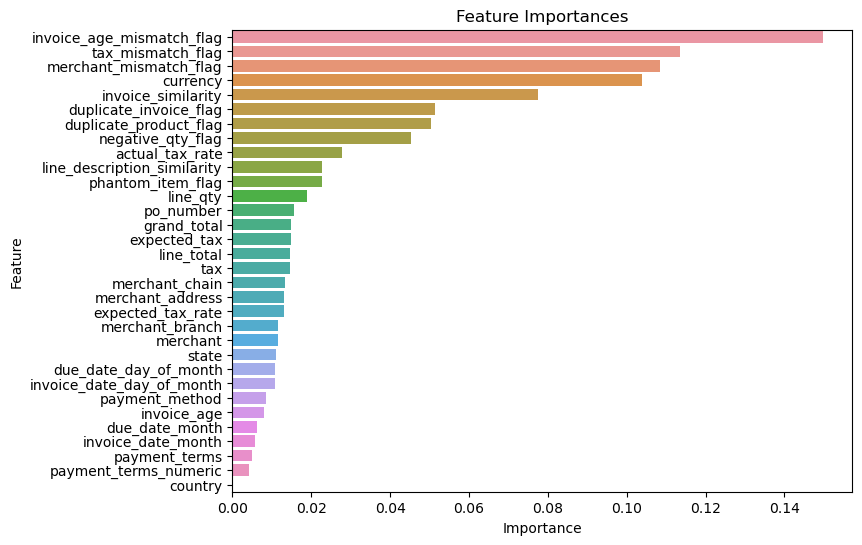

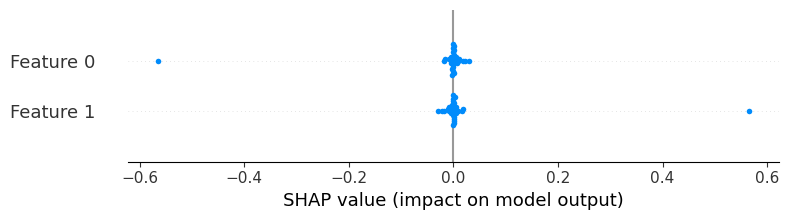


Confusion Matrix:
 [[1197    1]
 [  95  815]]
AUC: 0.9738575281146233


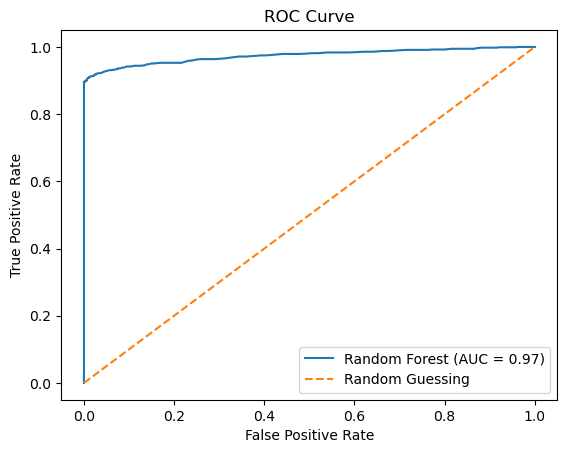

In [3]:
import pandas as pd
from feature_engine import datetime as fe_datetime
from sklearn import ensemble, metrics, preprocessing
import shap
import matplotlib.pyplot as plt
import seaborn as sns


# ---------------------
# 1) Load & Prep Data
# ---------------------
df_train = pd.read_parquet("train_df.parquet", engine="pyarrow")
df_test = pd.read_parquet("test_df.parquet", engine="pyarrow")

X_train = df_train.drop(["is_anomalous", "_ANOMALY_TYPES_DROP_BEFORE_TRAINING_"], axis=1, errors="ignore")
y_train = df_train["is_anomalous"]
X_test = df_test.drop(["is_anomalous", "_ANOMALY_TYPES_DROP_BEFORE_TRAINING_"], axis=1, errors="ignore")
y_test = df_test["is_anomalous"]

# Identify categorical and datetime columns
label_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
datetime_cols = [col for col in X_train.columns if X_train[col].dtype == "datetime64[ns]"]

# Label encode each categorical column
for col in label_cols:
    encoder = preprocessing.OrdinalEncoder(
        handle_unknown="use_encoded_value", 
        unknown_value=-1
    )
    X_train[[col]] = encoder.fit_transform(X_train[[col]].astype(str))
    X_test[[col]] = encoder.transform(X_test[[col]].astype(str))

# Encode datetime columns
for col in datetime_cols:
    dtfs = fe_datetime.DatetimeFeatures(features_to_extract=["month", "day_of_month"])
    X_train = pd.concat(
        [X_train.drop(col, axis=1), pd.DataFrame(dtfs.fit_transform(X_train[[col]]))],
        axis=1,
    )
    X_test = pd.concat(
        [X_test.drop(col, axis=1), pd.DataFrame(dtfs.transform(X_test[[col]]))], 
        axis=1
    )

# --------------------------------------
# 2) Train Model & Basic Performance
# --------------------------------------
model = ensemble.RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", metrics.classification_report(y_test, y_pred))

# --------------------------------------
# 3) Feature Importances
# --------------------------------------
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance_df = feature_importance_df.sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=feature_importance_df,
    x="importance",
    y="feature",
    orient="h"  # horizontal bars
)

plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# --------------------------------------
# 4) SHAP Interpretation
# --------------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_values = shap_values[1] 

# SHAP summary plot (beeswarm)
shap.summary_plot(shap_values)

# --------------------------------------
# 5) Additional Metrics
# --------------------------------------
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba)
roc_auc = metrics.auc(fpr, tpr)

print("AUC:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [11]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Reorder X_test to match the feature order of feature_importance_df
ordered_features = feature_importance_df["feature"].tolist()
X_test_ordered = X_test[ordered_features]

# 2) Gather per-tree SHAP values for the positive class
shap_values_per_tree = []

for i, tree_estimator in enumerate(model.estimators_):
    explainer_tree = shap.TreeExplainer(tree_estimator)
    
    # tree_shap_vals has shape: (n_samples, n_features, n_classes)
    tree_shap_vals = explainer_tree.shap_values(X_test_ordered)
    # Now tree_shap_vals is shape: (2108, 32, 2)
    
    # Select only the SHAP array for class 1 along the last dimension
    # i.e., shap array at index = 1
    tree_shap_vals_class1 = tree_shap_vals[:, :, 1]  # => shape (2108, 32)
    
    shap_values_per_tree.append(tree_shap_vals_class1)

# Convert list to numpy array => shape (500, 2108, 32)
shap_values_per_tree = np.array(shap_values_per_tree)
print(shap_values_per_tree.shape)
# Should be: (n_trees, n_samples, n_features) => (500, 2108, 32)

n_trees, n_samples, n_features = shap_values_per_tree.shape
rows = []
for tree_id in range(n_trees):
    for sample_idx in range(n_samples):
        for f_idx, f_name in enumerate(ordered_features):
            val = shap_values_per_tree[tree_id, sample_idx, f_idx]
            rows.append((tree_id, sample_idx, f_name, val))

df_shap = pd.DataFrame(rows, columns=["tree_id", "sample_idx", "feature", "shap_value"])
df_shap.head()



(500, 2108, 32)


,tree_id,sample_idx,feature,shap_value
0,0,0,invoice_age_mismatch_flag,0.006842
1,0,0,tax_mismatch_flag,0.000712
2,0,0,merchant_mismatch_flag,0.000287
3,0,0,currency,0.000067
4,0,0,invoice_similarity,0.013530


d:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


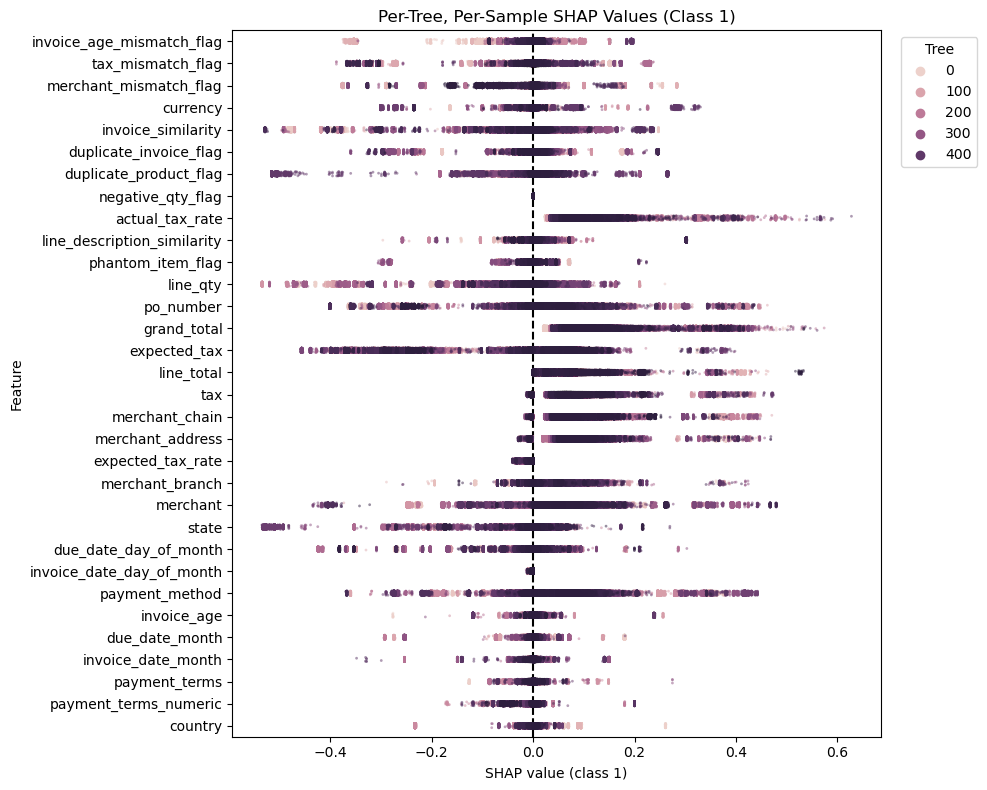

In [12]:
#    Plot: each dot is one (tree, sample) SHAP value
#    Features on y-axis, shap_value on x-axis. 
#    Hue by tree_id (can get busy if many trees).
plt.figure(figsize=(10, 8))
sns.stripplot(
    data=df_shap,
    x="shap_value",
    y="feature",
    hue="tree_id",       # color by tree
    jitter=True,
    size=2,
    alpha=0.5,
    orient="h"
)

plt.axvline(x=0, color='k', linestyle='--')
plt.title("Per-Tree, Per-Sample SHAP Values (Class 1)")
plt.xlabel("SHAP value (class 1)")
plt.ylabel("Feature")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Tree")
plt.tight_layout()
plt.show()